In [16]:
# импорты
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# нейронка
import torch
import torch.nn as nn

from math import ceil
from sqlalchemy import create_engine, text 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# модели
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# импорт метрик
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [17]:
# константы
RANDOM_STATE = 42

# фиксируем рандом
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.use_deterministic_algorithms(True)

In [18]:
# данные для соединения с БД

db_config = {
'user': 'praktikum_student',
'pwd': 'Sdf4$2;d-d30pp', 
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, 
'db': 'data-science-vehicle-db' 
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [19]:
engine = create_engine(connection_string)

Таблица `collisions` содержит информацию о происшествиях.

In [20]:
query = '''SELECT *
           FROM collisions'''
results_collisions = pd.DataFrame(engine.connect().execute(text(query)))
results_collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

In [21]:
results_collisions.head(3)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00


Таблица `Parties` содержит описание участников происшествия.

In [22]:
query = '''SELECT * 
           FROM parties'''
results_parties = pd.DataFrame(engine.connect().execute(text(query)))
results_parties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB


In [23]:
results_parties.head(3)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0


Таблица `Vehicles` содержит описание автомобиля.

In [24]:
query = '''SELECT *
           FROM vehicles'''
results_vehicles = pd.DataFrame(engine.connect().execute(text(query)))
results_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


In [25]:
results_vehicles.head(3)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0


Таблица `case_id` в ТЗ нет описания.

In [26]:
query = '''SELECT *
           FROM case_ids '''
results_case_ids = pd.DataFrame(engine.connect().execute(text(query)))
results_case_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB


In [27]:
results_case_ids.head(3)

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021


## Проведите первичное исследование таблиц

In [28]:
results_collisions.info()
results_collisions.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

,distance,intersection,party_count
count,1.400000e+06,1.387781e+06,1.400000e+06
mean,6.607115e+02,2.249087e-01,1.966006e+00
std,1.178579e+04,4.175223e-01,6.724457e-01
min,0.000000e+00,0.000000e+00,1.000000e+00
25%,2.000000e+00,0.000000e+00,2.000000e+00
50%,1.000000e+02,0.000000e+00,2.000000e+00
75%,4.300000e+02,0.000000e+00,2.000000e+00
max,8.363520e+06,1.000000e+00,2.700000e+01


В таблице о происшествиях присутствуют пустые значения. Cтолбцы не соответствуют своему типу данных. В данной таблице много категориальных признаков.

In [29]:
results_parties.info(verbose=True)
results_parties.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB


,id,party_number,at_fault,insurance_premium,cellphone_in_use
count,2.752408e+06,2.752408e+06,2.752408e+06,2.347006e+06,2.240771e+06
mean,1.376204e+06,1.598029e+00,4.680000e-01,3.874724e+01,2.045055e-02
std,7.945519e+05,7.236567e-01,4.989750e-01,1.637851e+01,1.415356e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.881028e+05,1.000000e+00,0.000000e+00,2.500000e+01,0.000000e+00
50%,1.376204e+06,1.000000e+00,0.000000e+00,3.600000e+01,0.000000e+00
75%,2.064306e+06,2.000000e+00,1.000000e+00,5.000000e+01,0.000000e+00
max,2.752408e+06,2.700000e+01,1.000000e+00,1.050000e+02,1.000000e+00


In [30]:
results_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


Присутствуют пустые значения, так же есть несоответствие типу данных. Отсутствует описание столбца `party_number`, возможно данный столбце излишен, т.к дублируется в другой таблице.

In [31]:
results_case_ids.info()
results_case_ids.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021


Данная таблица не описана в ТЗ, но служит для связи всех остальных таблиц, столбце `db_year` - скорее всего служит для обозначения года записи ДТП. 

##  Проведите статистический анализ факторов ДТП

Выясним, в какие месяцы происходит наибольшее количество аварий.

In [32]:
# sql так sql:)
query = '''SELECT EXTRACT(MONTH FROM collision_date) AS date_trunc,
                  count(*)   
           FROM collisions
           GROUP BY EXTRACT(MONTH FROM collision_date)'''

group_collisions_month = pd.DataFrame(engine.connect().execute(text(query)))

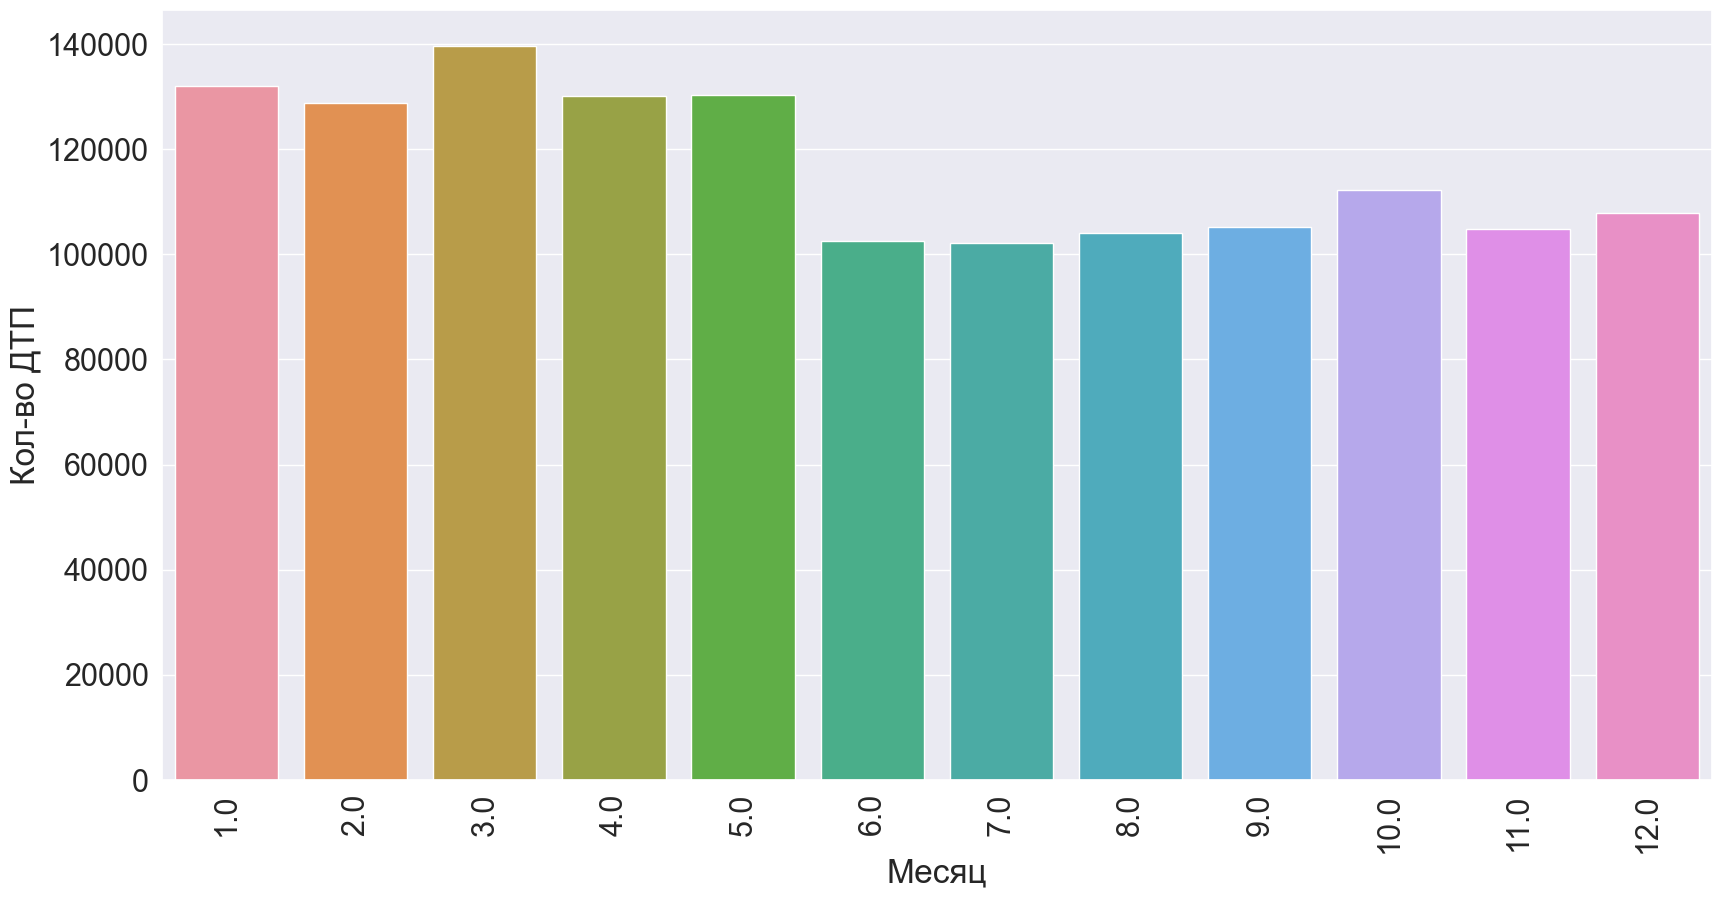

In [33]:
sns.set(rc={"figure.figsize":(20, 10)}, font_scale=2)
sns.barplot(x=group_collisions_month['date_trunc'], y=group_collisions_month['count']);
plt.xlabel('Месяц')
plt.ylabel('Кол-во ДТП')
plt.xticks(rotation=90)
plt.show()

С первого по пятый месяц включительно кол-во ДТП возрастает со 100 тыс. до 140 тыс, возможно это связано с погодными условиями и сменой сезона, т.е необходимостью менять шины. После пятого месяца кол-во ДТП возвращается в "норму" скорее всего это связано с началом сезона отпусков. После седьмого месяца кол-во ДТП начинает расти.

Посмотрим какая погода была в самые рискованные месяца для ДТП.

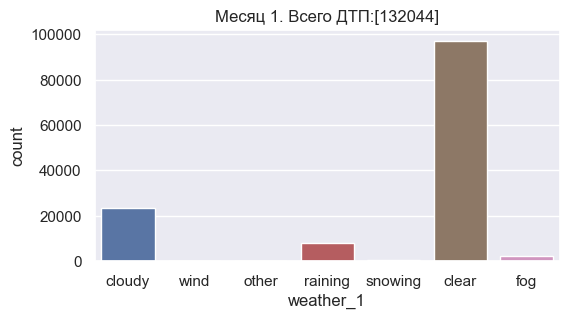

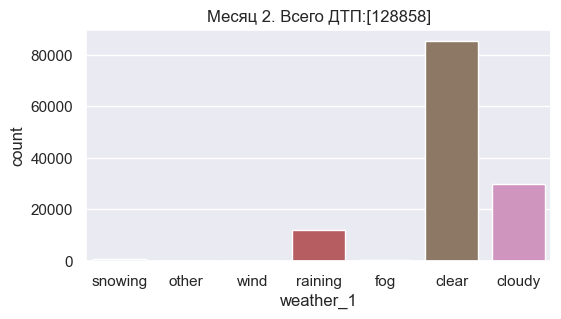

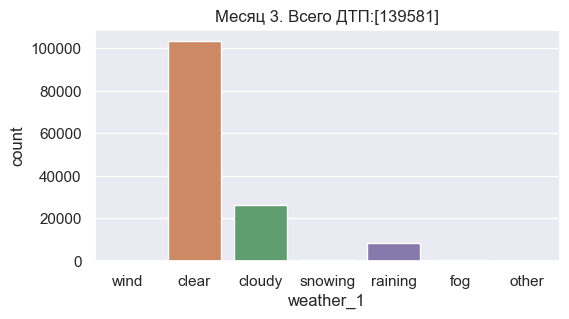

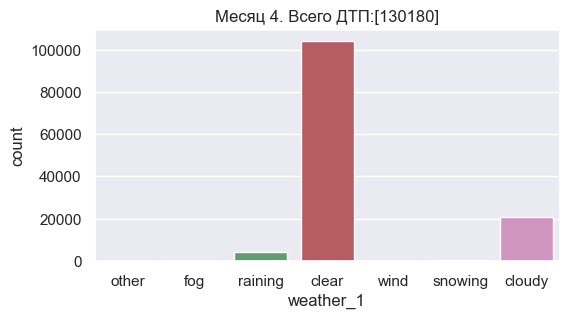

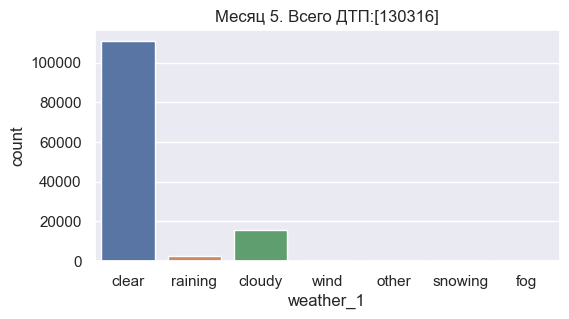

In [34]:
query = '''SELECT EXTRACT(MONTH FROM collision_date) AS date_trunc,
                  weather_1,  
                  count(*)   
           FROM collisions
           GROUP BY EXTRACT(MONTH FROM collision_date), WEATHER_1'''
group_collisions_month_weather = pd.DataFrame(engine.connect().execute(text(query)))

sns.set(rc={"figure.figsize":(6, 3)}, font_scale=1)

plt.xlabel('Погода')
plt.ylabel('Кол-во')

for i in range(1, 6): 
    query = 'date_trunc == ' + str(i)
    dtp_per_month = group_collisions_month_weather.query(query).groupby('date_trunc')['count'].sum() 
    plt.title('Месяц ' + str(i) + '. Всего ДТП:' + str(dtp_per_month.values))  
    sns.barplot(y=group_collisions_month_weather.query(query)['count'], 
                x=group_collisions_month_weather.query(query)['weather_1']);
    
    plt.show()

Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties)

In [35]:
query = '''select c.road_surface,
                  c.collision_damage,
                  count(c.*)
          from collisions c 
          join parties p on p.case_id = c.case_id 
          where p.at_fault = 1 
              and c.road_surface is not NULL
          group by c.road_surface, c.collision_damage
          order by count DESC'''
tmp_data = pd.DataFrame(engine.connect().execute(text(query)))

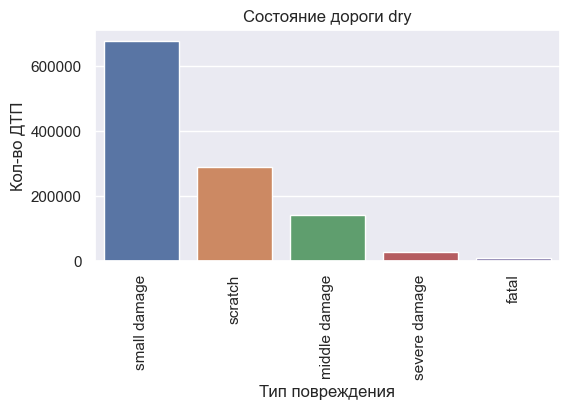

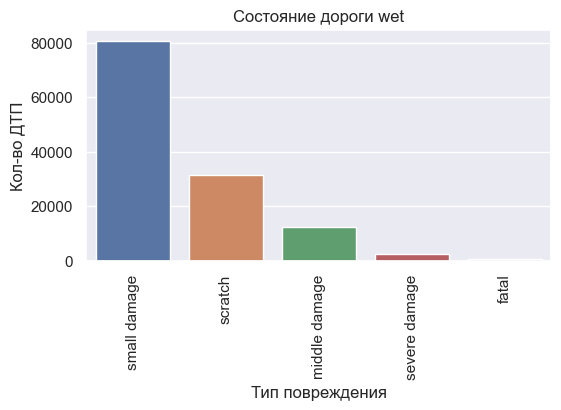

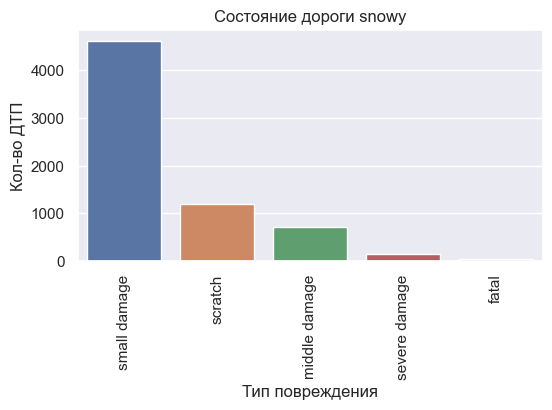

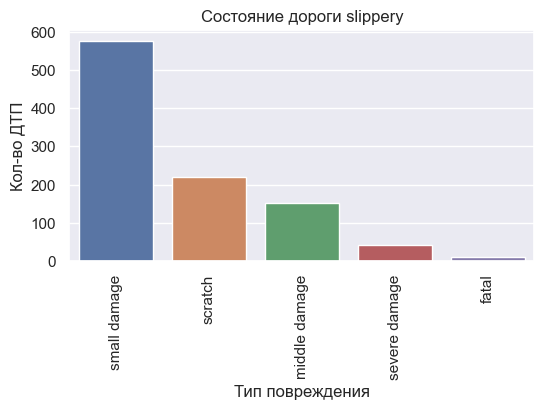

In [36]:
list_of_road = tmp_data['road_surface'].unique()

for value in list_of_road:
    query = 'road_surface == \'' + str(value) + '\''
    sns.barplot(x=tmp_data.query(query)['collision_damage'],y=tmp_data.query(query)['count']);
    plt.title('Состояние дороги ' + str(value))
    plt.xlabel('Тип повреждения')
    plt.ylabel('Кол-во ДТП')
    plt.xticks(rotation=90)
    plt.show()

В зависимости от погоды варьируются и повреждения:

* Если дорога сухая - больше всего царапин.
* Если дорога влажная - повреждения из царапин перетекают в "средние повреждения", но меньше "серьезных". А так же больше легких повреждений.
* Если дорога заснеженная - кол-во дтп падает.
* Меньше всего ДТП в на "скользкой, грязной" дороге. Но серьезность аварий выше, возможно из-за небольшой выборки.

Найдите самые частые причины ДТП (таблица parties)

In [37]:
query = '''select party_drug_physical,
                  count(*)  
           from parties
           where at_fault = 1
           group by party_drug_physical
           order by count desc
'''
tmp_data = pd.DataFrame(engine.connect().execute(text(query)))

In [38]:
tmp_data

,party_drug_physical,count
0,None,1066501
1,G,182724
2,not applicable,12801
3,under drug influence,12161
4,sleepy/fatigued,12066
5,impairment - physical,1874


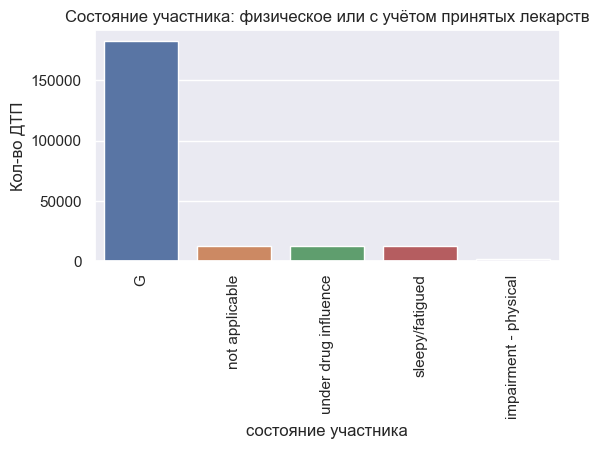

In [39]:
sns.barplot(x=tmp_data['party_drug_physical'],y=tmp_data['count']);
plt.title('Состояние участника: физическое или с учётом принятых лекарств')
plt.xlabel('состояние участника')
plt.ylabel('Кол-во ДТП')
plt.xticks(rotation=90)
plt.show()

В большинстве случаев физическое состояние Не известно (G) или не оценивалось (not applicable). Самые частые случаи под воздействием лекарств (Under Drug Influence) или в сонном состоянии.

In [40]:
query = '''select party_sobriety,
                  count(*)  
           from parties
           where at_fault = 1
           group by party_sobriety
           order by count desc
'''
tmp_data = pd.DataFrame(engine.connect().execute(text(query)))

In [41]:
tmp_data

,party_sobriety,count
0,had not been drinking,928820
1,impairment unknown,182724
2,"had been drinking, under influence",105946
3,None,28840
4,"had been drinking, impairment unknown",17052
5,not applicable,12801
6,"had been drinking, not under influence",11944


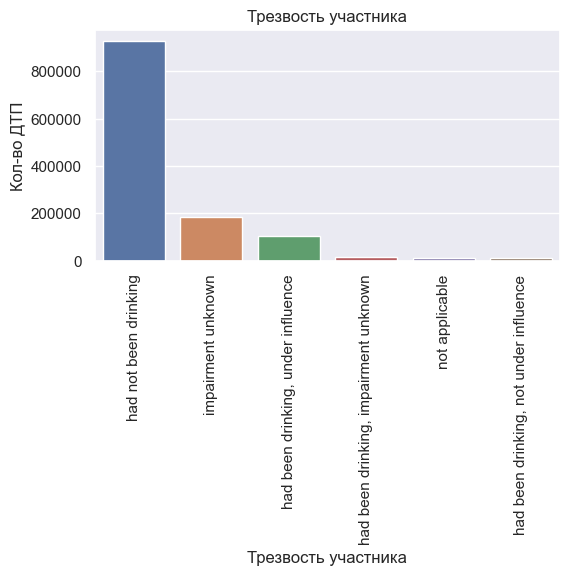

In [42]:
sns.barplot(x=tmp_data['party_sobriety'],y=tmp_data['count']);
plt.title('Трезвость участника')
plt.xlabel('Трезвость участника')
plt.ylabel('Кол-во ДТП')
plt.xticks(rotation=90)
plt.show()

В большинсте ДТП водители были трезвыми или состояние не отслеживалось, на третьем месте  идет алкогольное опьянение.
* 12 тыс. ДТП - под воздействием лекарст
* более 100 тыс. ДТП - в алкогольном опьянении.

Какие типы машин чаще всего попадают в ДТП (таблица collisions и vehicles).

In [43]:
query = '''select v.vehicle_type, 
                  p.at_fault 
           from collisions s
           join parties p on s.case_id = p.case_id 
           join vehicles v on s.case_id = v.case_id
             and v.party_number = p.party_number
           where p.at_fault = 1
'''
tmp_data = pd.DataFrame(engine.connect().execute(text(query)))

In [44]:
data_grouped = tmp_data.groupby('vehicle_type').count().reset_index()

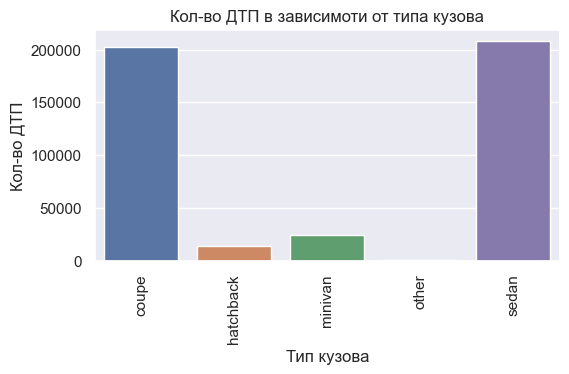

In [45]:
sns.barplot(x=data_grouped['vehicle_type'],y=data_grouped['at_fault']);
plt.title('Кол-во ДТП в зависимоти от типа кузова')
plt.xlabel('Тип кузова')
plt.ylabel('Кол-во ДТП')
plt.xticks(rotation=90)
plt.show()

Машины типа **купе** и **седан** чаще всего являются виновниками аварии, возможно - это самый распространённый тип машин. 

In [46]:
query = '''select v.vehicle_type,
                  count(*)
           from collisions s
           join parties p on s.case_id = p.case_id 
           join vehicles v on s.case_id = v.case_id
             and v.party_number = p.party_number
           group by v.vehicle_type  
'''
tmp_data = pd.DataFrame(engine.connect().execute(text(query)))

Посмотрим на количество машин по типу, вне зависимости от виновника.

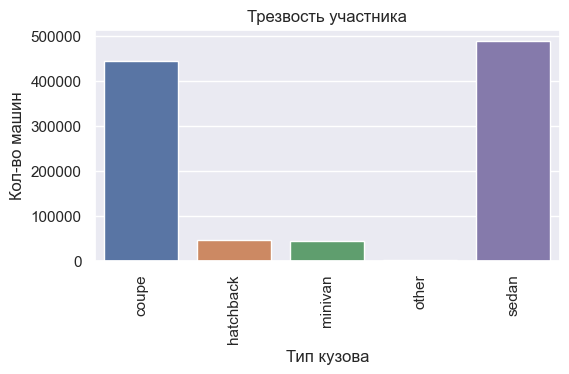

In [47]:
sns.barplot(x=tmp_data['vehicle_type'],y=tmp_data['count']);
plt.title('Трезвость участника')
plt.xlabel('Тип кузова')
plt.ylabel('Кол-во машин')
plt.xticks(rotation=90)
plt.show()

Действительно в данных, количество машин типа купе и седан большинство.

### Создайте не менее шести задач для коллег. Опирайтесь на примеры и таблицы

Количество происшествий в зависимости от  номера дня (ПН-ПТ). Возможно, ближе к выходным кол-во происшествий возрастает в зависимости от состояния водителя.

Происшествия в зависимости от состояния участника и типа кузова. К примеру, семейные люди чаще употребляют вещества приводящие к ДТП.

Серьезность ДТП от степени алкогольно опьянения.

Количество происшествий в зависимости от времени суток и состояния участника.

Серьезность происшествия в зависимости от наличия телефона в автомобиле.

Серьезность происшествия от фактора аварии.

Количество участников ДТП и возраст автомобиля.

## Создайте модель для оценки водительского риска

In [48]:
query = '''select c.case_id,
                  p.party_sobriety,
                  v.vehicle_type,
                  v.vehicle_transmission,
                  v.vehicle_age,
                  c.intersection,
                  c.weather_1,
                  c.road_surface,
                  c.lighting,
                  c.road_condition_1, 
                  c.location_type,
                  p.party_drug_physical,
                  p.cellphone_in_use,
                  c.collision_time,
                  p.at_fault
            from collisions c 
            join parties p on c.case_id  = p.case_id 
            join vehicles v on p.case_id = v.case_id 
                and p.party_number = v.party_number 
            where c.collision_damage != 'scratch'
                and EXTRACT(YEAR FROM c.collision_date) = 2012
                and p.party_type = 'car' '''
data = pd.DataFrame(engine.connect().execute(text(query)))

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   case_id               56248 non-null  object 
 1   party_sobriety        55376 non-null  object 
 2   vehicle_type          56248 non-null  object 
 3   vehicle_transmission  55389 non-null  object 
 4   vehicle_age           54554 non-null  float64
 5   intersection          56073 non-null  float64
 6   weather_1             56080 non-null  object 
 7   road_surface          55900 non-null  object 
 8   lighting              56094 non-null  object 
 9   road_condition_1      55999 non-null  object 
 10  location_type         25932 non-null  object 
 11  party_drug_physical   2857 non-null   object 
 12  cellphone_in_use      51777 non-null  float64
 13  collision_time        56160 non-null  object 
 14  at_fault              56248 non-null  int64  
dtypes: float64(3), int6

Заменим текст на категории в соответствии с ТЗ, тем самым облегчим вес БД. 

In [50]:
replace = {'had not been drinking': 'A', 
           'had been drinking, under influence': 'B',
           'had been drinking, not under influence': 'C',
           'had been drinking, impairment unknown': 'D',
           'impairment unknown': 'G',
           'not applicable': 'H'}
data['party_sobriety'] = data['party_sobriety'].fillna('U');
data['party_sobriety'] = data['party_sobriety'].apply(lambda x: replace[x] if x != 'U' else x)

In [51]:
replace = {'not applicable': 'H', 
           'sleepy/fatigued': 'I',
           'impairment - physical': 'F',
           'under drug influence': 'E'}

data['party_drug_physical'] = data['party_drug_physical'].fillna('U');
data['party_drug_physical'] = data['party_drug_physical'].apply(lambda x: replace[x] if x not in ['U', 'G'] else x)

In [52]:
replace = {'clear': 'A', 
           'cloudy': 'B',
           'raining': 'C',
           'snowing': 'D',
           'fog': 'E',
           'other': 'F',
           'wind': 'G'}

data['weather_1'] = data['weather_1'].fillna('U');
data['weather_1'] = data['weather_1'].apply(lambda x: replace[x] if x != 'U' else x)

In [53]:
replace = {'daylight': 'A', 
           'dark with no street lights': 'D',
           'dark with street lights': 'C',
           'dusk or dawn': 'B',
           'dark with street lights not functioning': 'E',
           }

data['lighting'] = data['lighting'].fillna('U');
data['lighting'] = data['lighting'].apply(lambda x: replace[x] if x != 'U' else x)

In [54]:
data['road_surface'].unique()

array(['dry', 'wet', 'snowy', None, 'slippery'], dtype=object)

In [55]:
replace = {'dry': 'A', 
           'wet': 'D',
           'snowy': 'C',
           'slippery': 'B',
           }

data['road_surface'] = data['road_surface'].fillna('U');
data['road_surface'] = data['road_surface'].apply(lambda x: replace[x] if x != 'U' else x)

In [56]:
data['location_type'].unique()

array([None, 'ramp', 'highway', 'intersection'], dtype=object)

In [57]:
replace = {'highway': 'H', 
           'ramp': 'R',
           'intersection': 'I',
           }

data['location_type'] = data['location_type'].fillna('U');
data['location_type'] = data['location_type'].apply(lambda x: replace[x] if x != 'U' else x)

Первичный отбор факторов, необходимых для модели.

In [58]:
columns =['party_sobriety', # Трезвость участника - данная характеристика значительно влияет на ДТП
          'vehicle_type', # Тип кузова, возможно машины с различным типом кузова, управляются по разному
          'vehicle_transmission', # КПП вполне может стать причино ДТП, если к примеру человек ни когда не пользовался тем или инным типом
          'vehicle_age', # Возраст машины - влияет на ее состояние, а значит ДТП могло произойти из-зи поломки
          'intersection', # Перекресток может являться наиболее опасным местом на дороге
          'weather_1', # Погодные условия определенно влияют на риск ДТП
          'road_surface', # Состояние дороги (сухая, мокрая и т/д) напрямую влияет на ДТП
          'lighting', # освещение
          'location_type', # тип дороги
          'party_drug_physical', # физическое состояние
          'road_condition_1', # Дорожное состояние (имеет физ повреждения), таблица collisions
          'at_fault' # целевая переменная
         ] 

In [59]:
data[columns].head(3)

,party_sobriety,vehicle_type,vehicle_transmission,vehicle_age,intersection,weather_1,road_surface,lighting,location_type,party_drug_physical,road_condition_1,at_fault
0,A,sedan,manual,2.0,0.0,B,A,A,U,U,normal,1
1,A,sedan,auto,NaN,0.0,A,A,A,U,U,normal,0
2,A,sedan,auto,2.0,0.0,B,A,A,U,U,normal,0


In [60]:
# проверим на дубли
data.drop('case_id', axis=1)[data.duplicated()].count()

party_sobriety          124
vehicle_type            124
vehicle_transmission    122
vehicle_age             118
intersection            123
weather_1               124
road_surface            124
lighting                124
road_condition_1        123
location_type           124
party_drug_physical     124
cellphone_in_use        112
collision_time          124
at_fault                124
dtype: int64

Дубли по case_id появились в результате того, что в одном происшествии могло быть несколько участников. 

In [61]:
def analize(column_name, xlabel, ylabel):
    display(data[column_name].unique())
    data_grouped = data.groupby(column_name)[column_name].count()
    sns.barplot(x=data_grouped.index, y=data_grouped)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.show()

Проверим категориальные переменные на уникальность.

array(['A', 'U', 'G', 'B', 'C', 'H', 'D'], dtype=object)

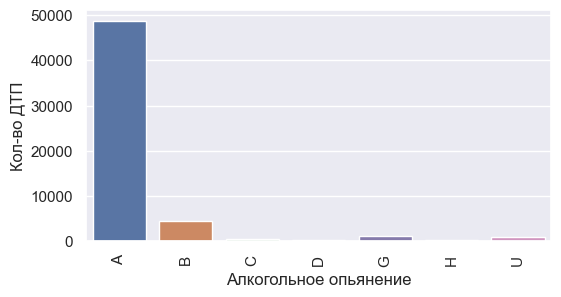

In [62]:
analize('party_sobriety', 'Алкогольное опьянение', 'Кол-во ДТП')

Для данного столбца лучше использовать категориально-буквенное обозначение.

Большинство ДТП произошло под влиянием алкоголя.

array(['U', 'E', 'G', 'I', 'H', 'F'], dtype=object)

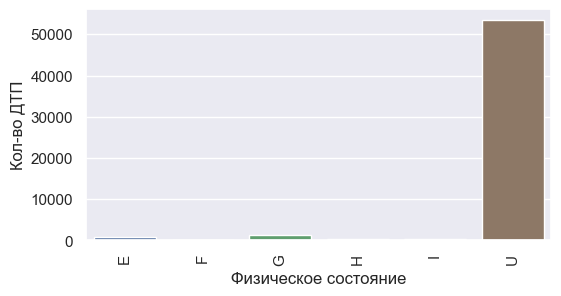

In [63]:
analize('party_drug_physical', 'Физическое состояние', 'Кол-во ДТП')

Категориальные значения в данном столбце записаны по разному, т.е одно из значений записано в сокращенном виде, а другие нет. Необходимо каждое значения писать в сокращенном виде.

Большинство состояний не оценивалось, но влияние на целевую переменную есть.

In [64]:
data['cellphone_in_use'].unique()

array([ 0., nan,  1.])

array([ 0., nan,  1.])

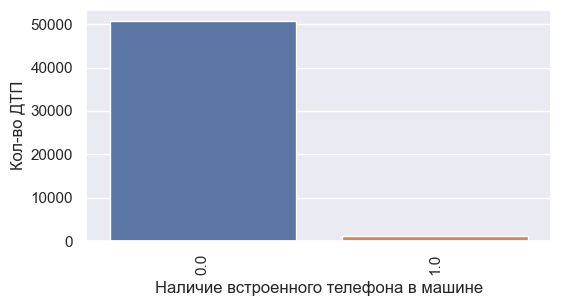

In [65]:
analize('cellphone_in_use', 'Наличие встроенного телефона в машине', 'Кол-во ДТП')

Скорее всего присутствие телефона в машине - является редкостью.

array([ 0.,  1., nan])

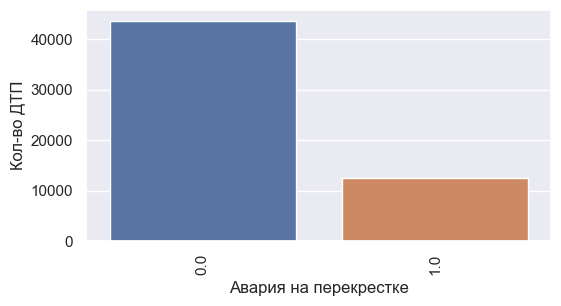

In [66]:
analize('intersection', 'Авария на перекрестке', 'Кол-во ДТП')

А вот наличие перекрестка влияет на вероятность ДТП.

array(['B', 'A', 'C', 'E', 'D', 'U', 'F', 'G'], dtype=object)

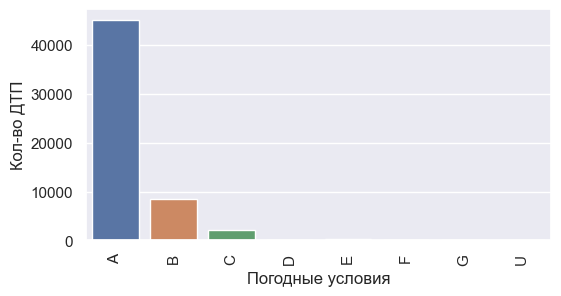

In [67]:
analize('weather_1', 'Погодные условия', 'Кол-во ДТП')

Большинство аварий произошло в чистую погоду, есть так же в прохладную и в дождливую. Возможно, аварии происходили на следующий день после плохой погоды. Необходимо проанализировать состояние дороги.

array(['A', 'D', 'C', 'U', 'B'], dtype=object)

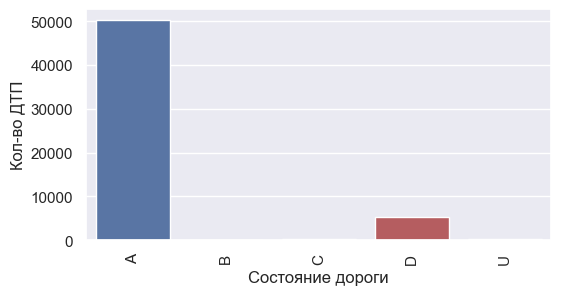

In [68]:
analize('road_surface', 'Состояние дороги', 'Кол-во ДТП')

Состояние дороги совпадает с погодой.

array(['A', 'C', 'D', 'B', 'U', 'E'], dtype=object)

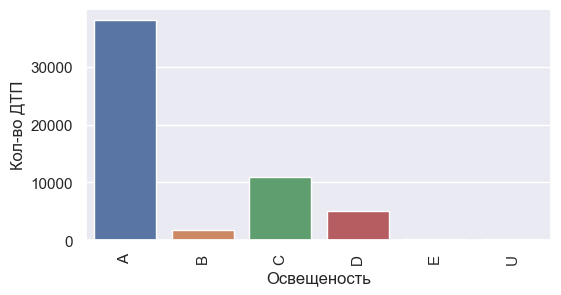

In [69]:
analize('lighting', 'Освещеность', 'Кол-во ДТП')

При дневном свете аварий больше всего, что и не удивительно. Возможно, освещение играет не столь важную роль.

array(['U', 'R', 'H', 'I'], dtype=object)

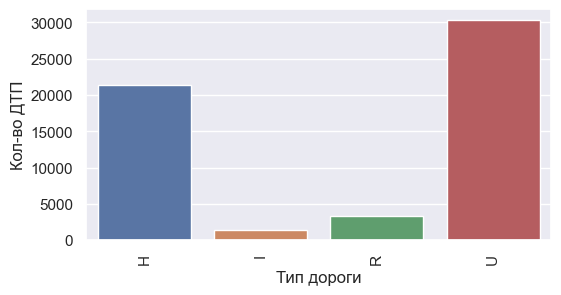

In [70]:
analize('location_type', 'Тип дороги', 'Кол-во ДТП')

Шоссе скорее всего является самым распространенным типом дорог. Логично предположить что чем хуже состояние дороги, тем выше вероятность ДТП.

array(['normal', 'construction', 'other', 'reduced width', 'holes',
       'obstruction', None, 'loose material', 'flooded'], dtype=object)

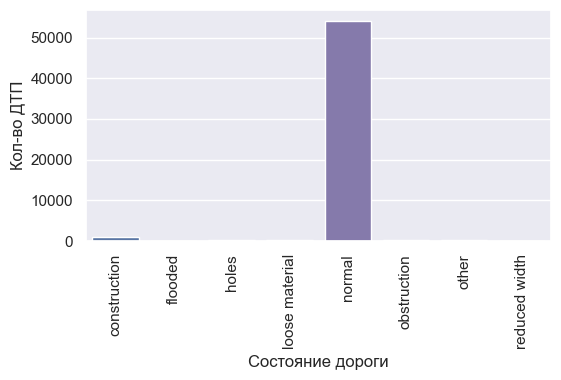

In [71]:
analize('road_condition_1', 'Состояние дороги', 'Кол-во ДТП')

Либо данная информация не отображает реальности, либо стостояние дорог маловероятно влияет на ДТП.

In [72]:
def convert_time_to_section(x):
    section_name = 'none';
    hour = str(x).split(':')[0]
    
    if hour == 'None':
        hour = -1
    else:
        hour = int(hour)
        
    if hour >= 6:
        section_name = 'part 1'
    elif hour >= 12:
        section_name = 'part 2'
    elif hour >= 18:
        section_name = 'part_3'
    elif hour < 6 and hour >= 0:
        section_name = 'part_4'
    else:
        section_name = 'other'
        
    return section_name

data['section_conllision_time'] = data['collision_time'].apply(lambda x: convert_time_to_section(x))

array(['part 1', 'part_4', 'other'], dtype=object)

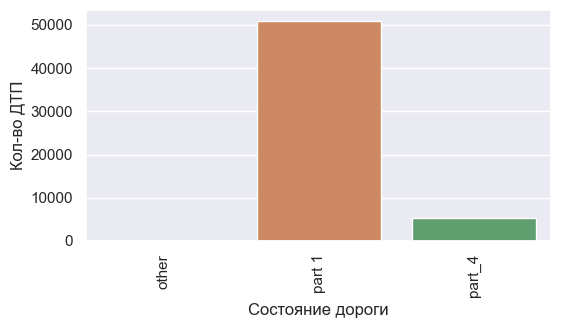

In [73]:
analize('section_conllision_time', 'Состояние дороги', 'Кол-во ДТП')

Большинство аварий происходило в час пик с 6 утра до 12 дня.

In [74]:
# тут есть выброс в 161 год
data['vehicle_age']

0         2.0
1         NaN
2         2.0
3        12.0
4         4.0
         ... 
56243     3.0
56244     2.0
56245    10.0
56246     9.0
56247     8.0
Name: vehicle_age, Length: 56248, dtype: float64

array(['sedan', 'coupe', 'other'], dtype=object)

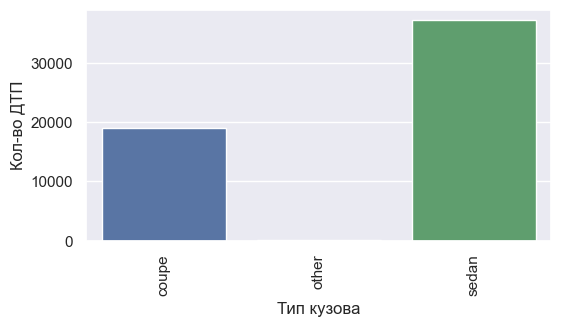

In [75]:
analize('vehicle_type', 'Тип кузова', 'Кол-во ДТП')

Проведем анализ числовых признаков.

In [76]:
data['vehicle_age'].describe().reset_index()

,index,vehicle_age
0,count,54554.000000
1,mean,4.856472
2,std,3.234503
3,min,0.000000
4,25%,3.000000
5,50%,4.000000
6,75%,7.000000
7,max,161.000000


Среднее больше медианы, максимальное значение отличатся от Q3 в несколько раз. В данных присутствуют выбросы.

In [77]:
data['vehicle_age'].value_counts()

3.0      11012
4.0       7157
2.0       6048
5.0       5565
6.0       3940
7.0       3838
8.0       3509
0.0       3087
9.0       2770
1.0       2545
10.0      1942
11.0      1380
12.0       879
13.0       551
14.0       282
15.0        37
16.0         6
17.0         3
161.0        2
19.0         1
Name: vehicle_age, dtype: int64

Отсечем все записи с автомобилями старше 15 лет.

In [78]:
data = data.query('vehicle_age < 16')

In [79]:
# заполним пропуски медианой
data[data['vehicle_age'].isna()]['vehicle_age'] = data['vehicle_age'].median()

По результатам анализа из признаков можно убрать:
* Тип участника происшествия - по умолчанию отобран тип "машина"
* наличие телефона
* состояние дороги

Категориальные данные необходимо привести в целочисленый вид.

Возможно, столбец `party_drug_physical` стоит удалить, т.к более 90% данных будут сгенерированы искусственно. 

In [80]:
columns = ['party_sobriety', # Уровень трезвости виновника (точно может влиять) Таблица parties
          #'party_drug_physical', # Состояние участника - физ/под воздействием лекарств
          'collision_time', # Время суток ДТП, возможно, большая часть ДТП происходить в определенное время суток
          'intersection', # Перекресток может являться наиболее опасным местом на дороге
          'weather_1', # Погодные условия определенно влияют на риск ДТП
          'road_surface', # Состояние дороги (сухая, мокрая и т/д) напрямую влияет на ДТП
          'lighting', # освещение
          'location_type', # тип дороги
          'vehicle_type',
          'vehicle_age',
          'at_fault' # целевая переменная
         ] 

In [81]:
data = data[columns]

In [82]:
data.info()
data.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54542 entries, 0 to 56247
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   party_sobriety  54542 non-null  object 
 1   collision_time  54458 non-null  object 
 2   intersection    54374 non-null  float64
 3   weather_1       54542 non-null  object 
 4   road_surface    54542 non-null  object 
 5   lighting        54542 non-null  object 
 6   location_type   54542 non-null  object 
 7   vehicle_type    54542 non-null  object 
 8   vehicle_age     54542 non-null  float64
 9   at_fault        54542 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 4.6+ MB


,party_sobriety,collision_time,intersection,weather_1,road_surface,lighting,location_type,vehicle_type,vehicle_age,at_fault
0,A,13:22:00,0.0,B,A,A,U,sedan,2.0,1
2,A,18:32:00,0.0,B,A,A,U,sedan,2.0,0
3,A,12:31:00,0.0,A,A,A,R,sedan,12.0,0


Некоторые пустые значения, были заполнены заглушками. Заполним пустые значения для столбца `intersection`.

In [83]:
grouped_fill_intersection = data.groupby('location_type')[
    ['location_type',
     'intersection']
].median().reset_index()

dict_intersection = dict(zip(grouped_fill_intersection['location_type'], 
                             grouped_fill_intersection['intersection']))
data.loc[
    data['intersection'].isna(),'intersection'
] = data['location_type'].apply(lambda x: dict_intersection[x])

C:\Users\User\AppData\Local\Temp\ipykernel_15568\3804526446.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ].median().reset_index()


In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54542 entries, 0 to 56247
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   party_sobriety  54542 non-null  object 
 1   collision_time  54458 non-null  object 
 2   intersection    54542 non-null  float64
 3   weather_1       54542 non-null  object 
 4   road_surface    54542 non-null  object 
 5   lighting        54542 non-null  object 
 6   location_type   54542 non-null  object 
 7   vehicle_type    54542 non-null  object 
 8   vehicle_age     54542 non-null  float64
 9   at_fault        54542 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 6.6+ MB


In [85]:
# почистим от дублей
data = data.drop_duplicates()

### Вывод 

Данные были собраны в один дата сет из нескольких таблиц по условиям из ТЗ. В результате пред. обработки убраны выбросы, дубликаты, а категориальные переменные скорректированы. Проанализированы зависимости между целевым признаком и остальными:

* `party_sobriety` - уровень трезвости, влияет на ДТП
* `intersection` - перекресток, влияет на ДТП
* `vehicle_type ` - тип кузова, влияет на ДТП

Погодные условия и состояние дороги незначительно влияют на ДТП, т.к в данном штате - аномальные условия являются редкостью.

Разобьем данные на трей и тест выборку, закодируем категориальные и числовые признаки.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['at_fault'], axis=1), 
                                                    data['at_fault'],
                                                    test_size=0.4,
                                                    shuffle=True, 
                                                    random_state=RANDOM_STATE)

In [87]:
X_catboost_train = X_train.copy()
X_catboost_train = X_catboost_train.drop(['collision_time',  'weather_1'], axis=1)

In [88]:
X_catboost_test = X_test.copy()
X_catboost_test = X_catboost_test.drop(['collision_time',  'weather_1'], axis=1)

In [89]:
# кодируем категориальные признаки

ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')

columns = ['party_sobriety',
            #'weather_1', - убрал, потому что крашиться ядро, скорее всего слишком много данных
            'road_surface',
            'lighting',
            'vehicle_type',
            #'intersection'
            'location_type' #- убрал, потому что крашиться ядро, скорее всего слишком много данных
          ]
cat_columns = columns
ohe.fit(X_train[columns])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [90]:
X_train[ohe.get_feature_names_out()] = ohe.transform(X_train[columns])

In [91]:
X_train = X_train.drop(columns, axis=1)

In [92]:
X_test[ohe.get_feature_names_out()] = ohe.transform(X_test[columns])

In [93]:
X_test = X_test.drop(columns, axis=1)

In [94]:
# масштабирование числовых признаков
scaler = StandardScaler()
columns = ['vehicle_age']
#X_train['vehicle_age']
X_train[columns] = scaler.fit_transform(X_train[columns])
X_test[columns] = scaler.transform(X_test[columns])

X_catboost_train[columns] = scaler.fit_transform(X_catboost_train[columns])

In [95]:
X_train = X_train.drop(columns, axis=1)
X_train = X_train.drop(['collision_time',  'weather_1'], axis=1)

In [96]:
X_test = X_test.drop(columns, axis=1)
X_test = X_test.drop(['collision_time',  'weather_1'], axis=1)

In [97]:
def stats(metrics, y_test, preds, model_name):
    report = classification_report(y_test, preds, target_names=['Non-churned', 'Churned']) 
    metrics = metrics.append(pd.DataFrame({'recall': recall_score(y_test, preds)}, index=[model_name]))  
    return metrics, report

In [98]:
def fmodel(model, params, X_train, y_train, X_test, cv=4, scoring='recall'):   
    gs = GridSearchCV(model, params, cv=cv, scoring=scoring)
    gs.fit(X_train, y_train)
    
    preds = gs.best_estimator_.predict(X_test)
    
    return preds, gs.best_estimator_

In [99]:
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=RANDOM_STATE)
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 0.3, 0.5, 0.7, 0.9, 1]
}

preds, best_model = fmodel(model, params, X_train, y_train, X_test)
metrics, report = stats(pd.DataFrame(), y_test, preds, 'LogReg')

print(report)

              precision    recall  f1-score   support

 Non-churned       0.58      0.78      0.66      8532
     Churned       0.71      0.49      0.58      9464

    accuracy                           0.62     17996
   macro avg       0.64      0.63      0.62     17996
weighted avg       0.65      0.62      0.62     17996



C:\Users\User\AppData\Local\Temp\ipykernel_15568\747888224.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd.DataFrame({'recall': recall_score(y_test, preds)}, index=[model_name]))


In [100]:
model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
params = {
    'n_estimators': range(40, 180, 30),
    'max_depth': [8]
}

preds, best_model = fmodel(model, params, X_train, y_train, X_test)
metrics, report = stats(metrics, y_test, preds, 'RandomForestGV')

print(report)

              precision    recall  f1-score   support

 Non-churned       0.58      0.79      0.67      8532
     Churned       0.71      0.48      0.57      9464

    accuracy                           0.63     17996
   macro avg       0.65      0.63      0.62     17996
weighted avg       0.65      0.63      0.62     17996



C:\Users\User\AppData\Local\Temp\ipykernel_15568\747888224.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd.DataFrame({'recall': recall_score(y_test, preds)}, index=[model_name]))


In [101]:
model = CatBoostClassifier(cat_features=cat_columns, random_state=RANDOM_STATE)
params = {
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations':[100]
}
preds, best_model = fmodel(model, params, X_catboost_train, y_train, X_catboost_test)

0:	learn: 0.6902425	total: 180ms	remaining: 17.8s
1:	learn: 0.6872612	total: 197ms	remaining: 9.66s
2:	learn: 0.6849415	total: 208ms	remaining: 6.73s
3:	learn: 0.6822837	total: 230ms	remaining: 5.51s
4:	learn: 0.6799635	total: 254ms	remaining: 4.83s
5:	learn: 0.6777726	total: 279ms	remaining: 4.37s
6:	learn: 0.6755720	total: 298ms	remaining: 3.95s
7:	learn: 0.6734621	total: 315ms	remaining: 3.62s
8:	learn: 0.6713464	total: 332ms	remaining: 3.35s
9:	learn: 0.6694366	total: 347ms	remaining: 3.12s
10:	learn: 0.6676045	total: 361ms	remaining: 2.92s
11:	learn: 0.6658769	total: 376ms	remaining: 2.75s
12:	learn: 0.6642410	total: 392ms	remaining: 2.63s
13:	learn: 0.6626158	total: 676ms	remaining: 4.15s
14:	learn: 0.6611500	total: 963ms	remaining: 5.46s
15:	learn: 0.6597984	total: 1.1s	remaining: 5.78s
16:	learn: 0.6583855	total: 1.15s	remaining: 5.59s
17:	learn: 0.6565316	total: 1.17s	remaining: 5.31s
18:	learn: 0.6548079	total: 1.19s	remaining: 5.06s
19:	learn: 0.6532489	total: 1.21s	remainin

In [102]:
recall_precision = pd.DataFrame({
    'CatBoostGV': [recall_score(y_test, preds), precision_score(y_test, preds)]
}, index=['recall', 'precision'])

cm = confusion_matrix(y_test, preds, labels=model.classes_)
metrics, report = stats(metrics, y_test, preds, 'CatBoost')

print(report)

              precision    recall  f1-score   support

 Non-churned       0.57      0.68      0.62      8532
     Churned       0.65      0.55      0.60      9464

    accuracy                           0.61     17996
   macro avg       0.61      0.61      0.61     17996
weighted avg       0.62      0.61      0.61     17996



C:\Users\User\AppData\Local\Temp\ipykernel_15568\747888224.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd.DataFrame({'recall': recall_score(y_test, preds)}, index=[model_name]))


In [103]:
# переведем все в тензор
X_tensor_train = torch.FloatTensor(X_train.values)
X_tensor_test = torch.FloatTensor(X_test.values)
y_tensor_train = torch.FloatTensor(y_train.values)
y_tensor_test = torch.FloatTensor(y_test.values)

In [104]:
input_size = X_train.shape[1]
hidden_size = 4
num_classes = 1 

batch_size = 128
num_epochs = 21
num_batches = ceil(len(X_train) / batch_size)

In [105]:
n_in_neurons = input_size
n_hidden_neurons = 8
#n_hidden_neurons_2 = 4
n_out_neurons = num_classes

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons),
    nn.Dropout(p=0.4),
    nn.ReLU(),
    #nn.Linear(n_hidden_neurons, n_hidden_neurons_2),
    #nn.ReLU(),
    nn.Linear(n_hidden_neurons, n_out_neurons), 
    nn.Sigmoid()
)


loss = nn.BCELoss() 

accumulation_iteration = 5 # делать оптимизационный шаг каждый 5-й батч
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [106]:
recall = 0
for epoch in range(num_epochs):
    # случайная перестановка объектов
    order = np.random.permutation(len(X_tensor_train))
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        #optimizer.zero_grad()
        
        # получение индексов текущего батча
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_tensor_train[batch_indexes]
        y_batch = y_tensor_train[batch_indexes]
    
        preds = net.forward(X_batch).flatten()        
        loss_value = loss(preds, y_batch)
        loss_value.backward()              

        if ((batch_idx + 1) % accumulation_iteration == 0) or (batch_idx + 1 == num_batches):
            optimizer.step()
            optimizer.zero_grad()
        
        
    if epoch % 10 == 0:
        net.eval()
        test_preds = net.forward(X_tensor_test) 
        accuracy = (test_preds.argmax(dim=1) == y_tensor_test).float().mean().data
        
        if epoch == num_epochs - 1:
            test_preds[test_preds <= 0.5] = 0
            test_preds[test_preds > 0.5] = 1
                
            metrics, report = stats(metrics,
                y_tensor_test.reshape(-1, 1).detach().numpy(), 
                test_preds.detach().numpy(), 
                'NN')
            print(report)
         

              precision    recall  f1-score   support

 Non-churned       0.58      0.73      0.65      8532
     Churned       0.68      0.53      0.60      9464

    accuracy                           0.63     17996
   macro avg       0.63      0.63      0.62     17996
weighted avg       0.64      0.63      0.62     17996



C:\Users\User\AppData\Local\Temp\ipykernel_15568\747888224.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd.DataFrame({'recall': recall_score(y_test, preds)}, index=[model_name]))


### Выберите метрику для оценки модели, исходя из поставленной бизнесом задачи. 

Найдем как можно больше аварий, а для этого нам пригодиться метрика recall.

### Вывод

В результате выбора признаков и пред. обработки данных, тренировки моделей. Recall у лучшей модели с подбором параметров - CatBoost 55%

In [107]:
metrics

,recall
LogReg,0.488694
RandomForestGV,0.481509
CatBoost,0.547760
NN,0.534975


## Проверьте лучшую модель в работе

### Проведите графический анализ «Матрица ошибок». Выведите полноту и точность на график.

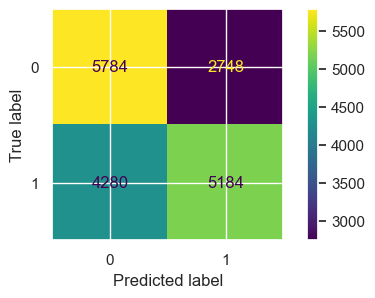

In [108]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
plt.show()

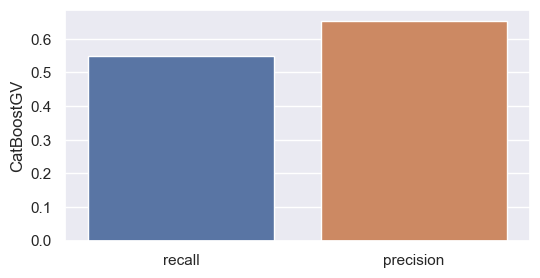

In [109]:
sns.barplot(x=recall_precision.index, y=recall_precision['CatBoostGV'])
plt.show()

Из всех классов **1** модели видит около 57%, а правильно определяет до 70%.

### Проанализируйте важность основных факторов, влияющих на вероятность ДТП.

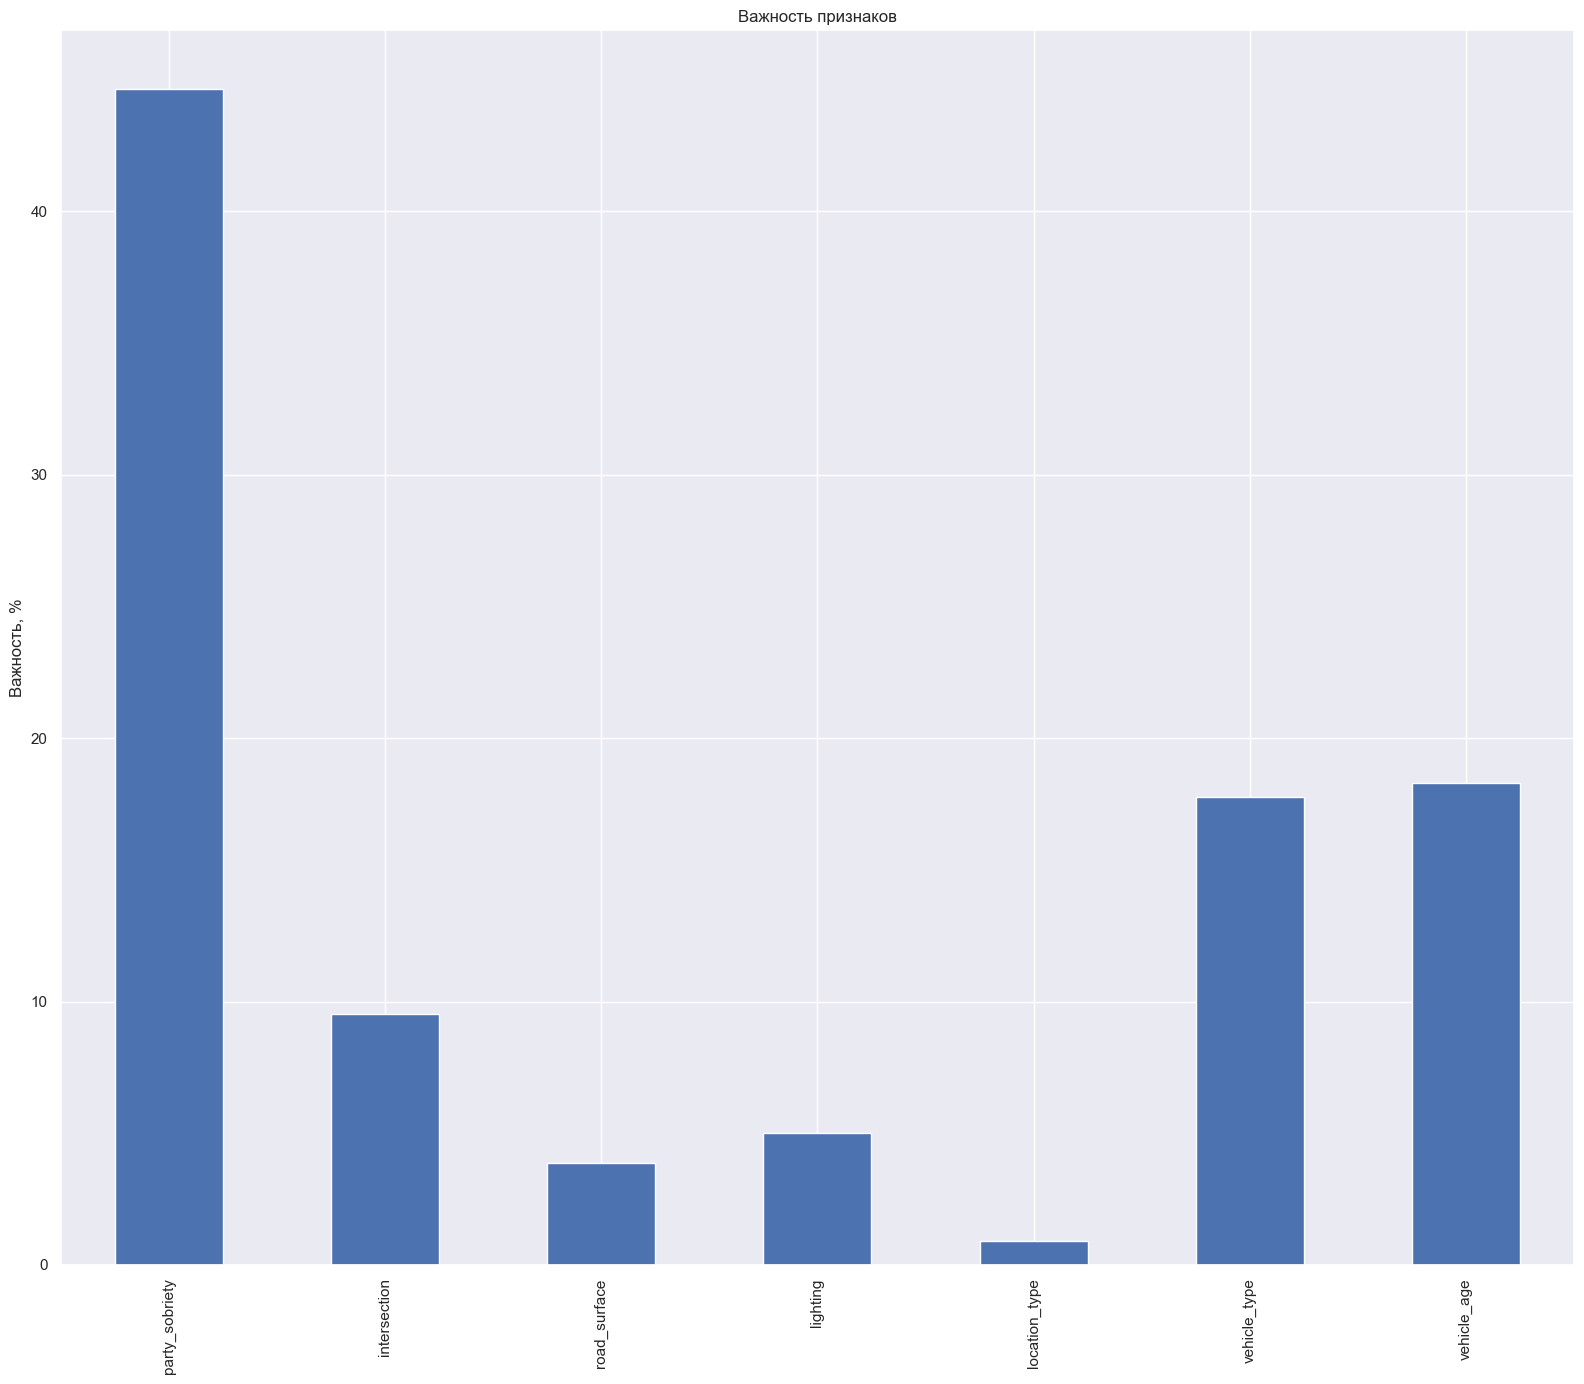

In [110]:
feaure_importance = pd.Series(best_model.get_feature_importance(),
                         X_catboost_train.columns)
fig, ax = plt.subplots(figsize=(16,14))
feaure_importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Из важных признаков стоит отметить:
* Трезвость участника: 
  - (B) Был пьян, под влиянием
  - (G) Неизвестно ухудшение
  - (D) Был пьян, ухудшение неизвестно
  - (C) Был пьян, не под влиянием
  - (U) - Состояние неизвестно
* Перекресток
  - Много аварий происходит на перекрестке.
* Тип кузова

Признак **Трезвость участника**: необходим дополнительный контроль за трезвостью водителя, к примеру, получать дополнительную информацию о штрафах водителя и применять систему демотивации в случае повышенного кол-ва штрафов за вождение в нетрезвом виде.

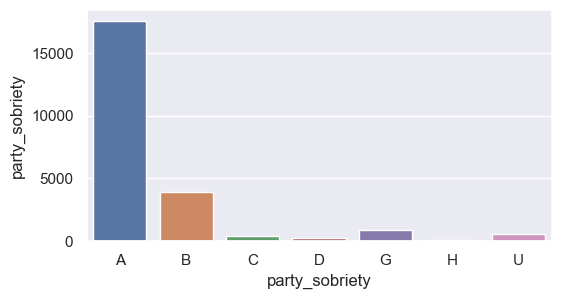

In [111]:
# получим кол-во аварий по категории трезвости
data_grouped = data.query('at_fault == 1').groupby('party_sobriety')['party_sobriety'].count()

sns.barplot(x=data_grouped.index, y=data_grouped)
plt.show()

Признак **Перекресток**: Встроить систему предупреждения, например "Внимание, аварийно опасный перекросток!". Это систему можно реализовать сбором информации об овариях на текущем перекрестке.

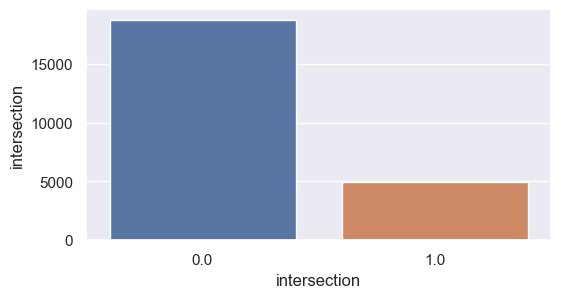

In [112]:
# получим кол-во аварий по категории трезвости
data_grouped = data.query('at_fault == 1').groupby('intersection')['intersection'].count()

sns.barplot(x=data_grouped.index, y=data_grouped)
plt.show()

Тип кузова так же имеет значимость.

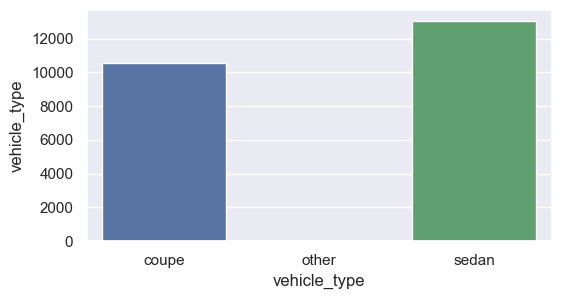

In [113]:
# получим кол-во аварий по категории трезвости
data_grouped = data.query('at_fault == 1').groupby('vehicle_type')['vehicle_type'].count()

sns.barplot(x=data_grouped.index, y=data_grouped)
plt.show()

## Выводы

Лучшая модель CatBoost, выбрана по Recall мера, т.к это среднее между полнотой и точностью.

In [114]:
metrics

,recall
LogReg,0.488694
RandomForestGV,0.481509
CatBoost,0.547760
NN,0.534975


При выдаче авто не стоит полагаться на системы тестирования трезвости водителя, возможно, это создаст отток клиентов. Более правильным решением будет опираться на информацию о водителе и его штрафах из этого формировать систему штрафов и бонусов для водителя.

К примеру, если у водителя много штрафов за вождение в нетрезвом виде, то либо отказывать ему в прокате, либо повышать прокатную цену и ограничивать ассортимент машин.

Создание адекватной модели **предупреждения аварий** вполне вероятно, но необходимо опираться на историю водителя и аварийноапсных участках дороги.